In [1]:
!pip install qiskit["all"]
!pip install qiskit[machine-learning]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 19.1 MB/s eta 0:00:00

# The Quantum Convolution Neural Network 

## 1. Introduction

Throughout this tutorial, we discuss a Quantum Convolutional Neural Network (QCNN), first proposed by Cong et. al. [1]. We implement such a QCNN on Qiskit by modeling both the convolutional layers and pooling layers using a quantum circuit. After building such a network, we train it to differentiate horizontal and vertical lines from a pixelated image. The following tutorial is thus divided accordingly;

1. Differences between a QCNN and CCNN
2. Components of a QCNN
3. Data Generation
4. Building a QCNN
5. Training our QCNN
6. Testing our QCNN
7. References

We first begin by importing the libraries and packages we will need for this tutorial. 

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

## 1. Differences between a QCNN and CCNN

### 1.1 Classical Convolutional Neural Networks

Classical Convolutional Neural Networks (CCNNs) are a subclass of artificial neural networks which have the ability to determine particular features and patterns of a given input. Because of this, they are commonly used in image recognition and audio processing.

The capability of determining features is a result of the two types of layers used in a CCNN, the convolutional layer and pooling layer. 

An example of a CCNN can be seen in Figure 1, where a CCNN is trained to determine whether an input image either contains a cat or a dog. To do so, the input image passes through a series of alternating convolutional (C) and pooling layers (P), all of which detect patterns and associate each pattern to a cat or a dog. The fully connected layer (FC) provides us with an output which allows us to determine whether the input image was a cat or dog.

The convolutional layer makes  use of a kernel, which can determine features and patterns of a particular input. An example of this is feature detection in an image, where different layers detect particular patterns in the input image. This is demonstrated in Figure 1, where the $l^{th}$ layer recognizes features and patterns along the $ij$ plane. It can then associate such features with a given output in the training process, and can use this process to train the dataset. 

On the other hand, a pooling layer reduces the dimensionality of the input data, reducing the computational cost and amount of learning parameters in the CCNN. A schematic of a CCNN can be seen below.

For further information on CCNN, see [2].

![Screenshot%202022-08-09%20at%2017.03.09.png](attachment:Screenshot%202022-08-09%20at%2017.03.09.png)
Figure 1. A schematic demonstration of the use of a CCNN to classify between images of a cat and dog. Here, we see the several convolutional and pooling layers being applied, all of which are decreasing in dimensionality due to the use of the pooling layers. The output of the CCNN determines whether the input image was a cat or dog. Image obtained form [1]. 

### 1.2 Quantum Convolutional Neural Networks 

Quantum Convolutional Neural Networks (QCNN) behave in a similar manner to CCNNs. First, we encode our pixelated image into a quantum circuit using a given feature map, such Qiskit's ZFeatureMap or ZZFeatureMap or others available in the circuit library.

After encoding our image, we apply alternating convolutional and pooling layers, as defined in the next section. By applying these alternating layers, we reduce the dimensionality of our circuit until we are left with one qubit. We can then classify our input image by measuring the output of this one remaining qubit.

The Quantum Convolutional Layer will consist of a series of two qubit unitary operators, which recognize and determine relationships between the qubits in our circuit. This unitary gates are defined below in the next section. 

For the Quantum Pooling Layer, we cannot do the same as is done classically to reduce the dimension, i.e. the number of qubits in our circuit. Instead, we reduce the number of qubits by performing operations upon each until a specific point and then disregard certain qubits in a specific layer. It is these layers where we stop performing operations on certain qubits that we call our 'pooling layer'. Details of the pooling layer is discussed further in the next section.

In the QCNN, each layer contains parametrized circuits, meaning we alter our output result by adjusting the parameters of each layer. When training our QCNN, it is these parameters that are adjusted to reduce the loss function of our QCNN. 

A simple example of four qubit QCNN can be seen below. 

![figure2.png](attachment:figure2.png)


Figure 2: Example QCNN containing four qubits. The first Convolutional Layer acts on all the qubits. This is followed by the first pooling layer, which reduces the dimensionality of the QCNN from four qubits to two qubits by disregarding the first two. The second Convolutional layer then detects features between the two qubits still in use in the QCNN, followed by another pooling layer, which reduces the dimensionality from two qubits to one, which will be our output qubit.

## 2. Components of a QCNN

As discussed in Section 1 of this tutorial, a CCNN will contain both convolutional and pooling layers. Here, we define these layers for the QCNN in terms of gates applied to a Quantum Circuit and demonstrate an example for each layer for 4 qubits. 

Each of these layers will contain parameters which are tuned throughout the training process to minimize the loss function and train the QCNN to classify between horizontal and vertical lines. 

In theory, one could apply any parametrized circuit for both the convolutional and pooling layers of our network. For example in [2], the Gellmann Matrices (which are the three dimensional generalization of the Pauli Matrices) are used as generators for each unitary gate acting on a pair of qubits. 

Here, we take a different approach and form our parametrized circuit based on the two qubit unitary as proposed in [3]. This states that every unitary matrix in $U(4)$ can be decomposed such that 

$$U = (A_1 \otimes A_2) \cdot N(\alpha, \beta, \gamma) \cdot (A_3 \otimes A_4)$$

where $A_j \in \text{SU}(2)$, $\otimes$ is the tensor product, and $N(\alpha, \beta, \gamma) = exp(i[\alpha \sigma_x\sigma_x + \beta \sigma_y\sigma_y + \gamma \sigma_z\sigma_z ])$, where $\alpha, \beta, \gamma$ are the parameters that we can adjust. 

From this, it is evident that each unitary depends on 15 parameters and implies that in order for the QCNN to be able to span the whole Hilbert space, each unitary in our QCNN must contain 15 parameters each. 

Tuning this large amount of parameters would be difficult and would lead to long training times. To overcome this problem, we restrict our ansatz to a particular subspace of the Hilbert space and define the two qubit unitary gate as $N(\alpha, \beta, \gamma)$. These two qubit unitaries, as seen in [3] can be seen below and are applied to all neighboring qubits each of the layers in the QCNN. 

Note that by only using $N(\alpha, \beta, \gamma)$ as our two qubit unitary for the parametrized layers, we are restricting our QCNN to a particular subspace, one in which the optimal solution may not be contained in and reducing the accuracy of the QCNN. For the purpose of this tutorial, we will use this parametrized circuit to decrease the training time of our QCNN.

![circuit2.png](attachment:circuit2.png)

Figure 3:
Parametrized two qubit unitary circuit for $N(\alpha, \beta, \gamma) = exp(i[\alpha \sigma_x\sigma_x + \beta \sigma_y\sigma_y + \gamma \sigma_z\sigma_z ])$ as seen in [3], where $\alpha =  \frac{\pi}{2} - 2\theta$, $\beta = 2\phi - \frac{\pi}{2}$ and $\gamma =  \frac{\pi}{2} - 2\lambda$ as seen in the circuit. This two qubit unitary will be applied to all neighboring qubits in our feature map. 

### 2.1 Convolutional Layer

The next step in this tutorial is to define the Convolutional Layers of our QCNN. These layers are then applied to the qubits after the data has been encoded through use of the feature map. 

To do so we first need to determine a parametrized unitary gate, which will be used to create our convolutional and pooling layers. 

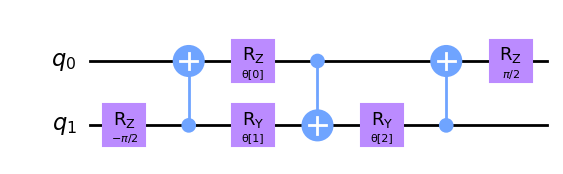

In [3]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

Now that we have defined these unitaries, it is time to create a function for the convolutional layer in our QCNN. To do so, we apply the two qubit unitary to neighboring qubits as seen in the ``conv_layer`` function below.

Note that we first apply the two qubit unitary to all even pairs of qubits followed by applying to odd pairs of qubits in a circular coupling manner, i.e. the as well as neighboring qubits being coupled, the first and final qubit are also coupled through a unitary gate.

Note that we add barriers into our quantum circuits for convenience when plotting, however they are not required for the actual QCNN and can be extracted from the following circuits.

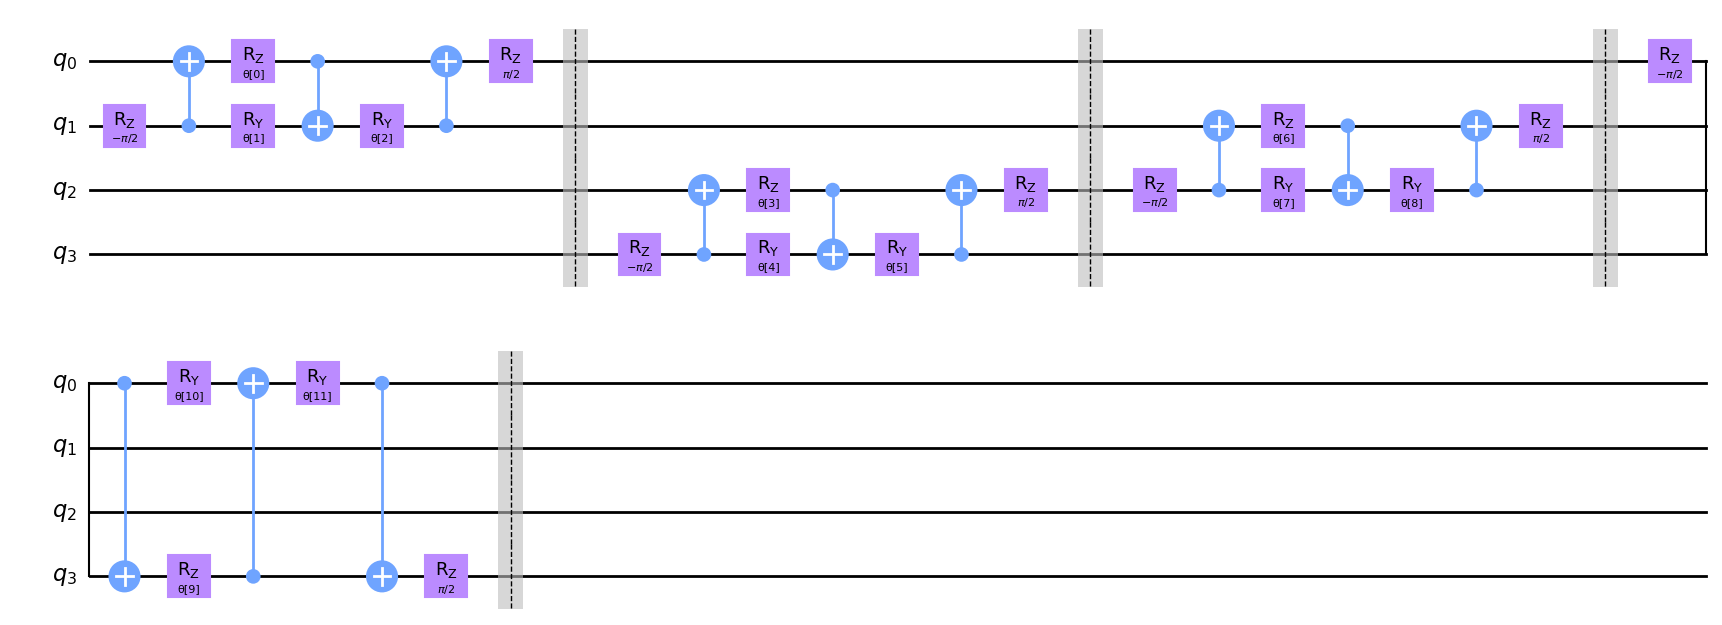

In [4]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

### 2.2 Pooling Layer

The purpose of a pooling layer is to reduce the dimensions of our Quantum Circuit, i.e. reduce the number of qubits in our circuit, while retaining as much information as possible from previously learned data. Reducing the amount of qubits also reduces the computational cost of the overall circuit, as the number of parameters that the QCNN needs to learn decreases. 

However, one cannot simply decrease the amount of qubits in our quantum circuit. Because of this, we must define the pooling layer in a different manner compared with the classical approach. 

To 'artificially' reduce the number of qubits in our circuit, we first begin by creating pairs of the $N$ qubits in our system. 

After initially pairing all the qubits, we apply our generalized 2 qubit unitary to each pair, as described previously. After applying this two qubit unitary, we then ignore one qubit from each pair of qubits for the remainder of the neural network. 

This layer therefore has the overall effect of 'combining' the information of the two qubits into one qubit by first applying the unitary circuit, encoding information from one qubit into another, before disregarding one of qubits for the remainder of the circuit and not performing any operations or measurements on it. 

We note that one could also apply a dynamic circuit to reduce the dimensionality in the pooling layers. This would involve performing measurements on certain qubits in the circuit and having an intermediate classical feedback loop in our pooling layers. By applying these measurements, one would also be reducing the dimensionality of the circuit. 

In this tutorial, we apply the former approach, and disregard qubits in each pooling layer. Using this approach, we thus create a QCNN Pooling Layer which transforms the dimensions of our $N$ qubit Quantum Circuit to $N/2$. 

To do so, we first define a two qubit unitary, which transforms the two qubit system to one. 


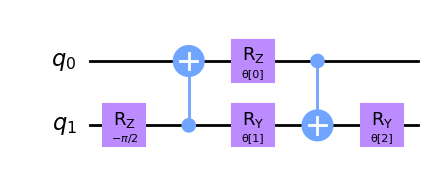

In [5]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

After applying this two qubit unitary circuit, we neglect the first qubit (q0) in future layers and only use the second qubit (q1) in our QCNN

We apply this two qubit pooling layer to different pairs of qubits to create our pooling layer for N qubits. As an example we then plot it for four qubits. 

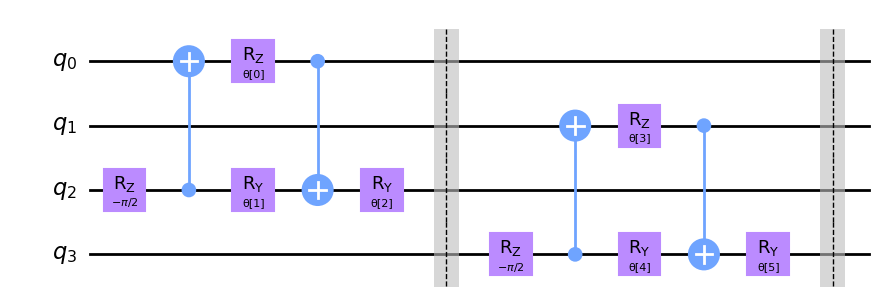

In [6]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In this particular example, we reduce the dimensionality of our four qubit circuit to the last two qubits, i.e. the last two qubits in this particular example. These qubits are then used in the next layer, while the first two are neglected for the remainder of the QCNN. 

## 3. Data Generation

One common use of a CCNN is an image classifier, where a CCNN detects particular features and patterns (such as straight lines or curves) of the pixelated images through the use of the feature maps in the convolutional layer. By learning the relationship between these features, it can then classify and label handwritten digits with ease. 

Because of a classical CNN's ability to recognize features and patterns easily, we will train our QCNN to also determine patterns and features of a given set of pixelated images, and classify between two different patterns. 

To simplify the dataset, we only consider 2 x 4 pixelated images. The patterns we will train the QCNN to distinguish will be a horizontal or vertical line, which can be placed anywhere in the image, alongside a noisy background. 

We first begin by generating this dataset. To create a 'horizontal' or 'vertical' line, we assign pixels value to be $\frac{\pi}{2}$ which will represent the line in our pixelated image. We create a noisy background by assigning every other pixel a random value between $0$ and $\frac{\pi}{4}$ which will create a noisy background. 

Note that when we create our dataset, we need to split it into the training set and testing set of images, the datasets we train and test our neural network respectively.

We also need to label our datasets such that the QCNN can learn to differentiate between the two patterns. In this example we label images with a horizontal line with -1 and images with a vertical line +1.

In [7]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

Let's now create our dataset below and split it into our test and training datasets.

In [8]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

Let's see some examples in our dataset

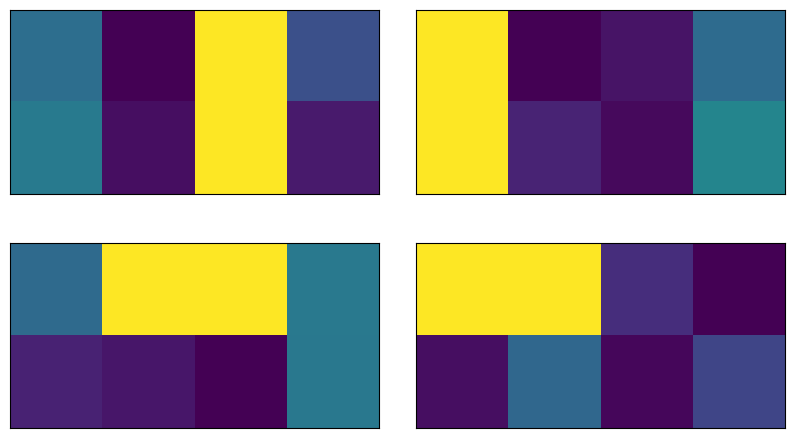

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

As we can see each image contains either a vertical or horizontal line, that the QCNN will learn how to differentiate. Now that we have built our dataset, it is time to discuss the components of the QCNN and build our model.

## 4. Modeling our QCNN

Now that we have defined both the convolutional layers it is now time to build our QCNN, which will consist of alternating pooling and convolutional layers.

As the images in our dataset contains 8 pixels, we will use 8 qubits in our QCNN. 

We encode our dataset into our QCNN by applying a feature map. One can create a feature map using one of Qiskit's built in feature maps, such as ZFeatureMap or ZZFeatureMap. 

After analyzing several different Feature maps for this dataset, it was found that QCNN obtains the greatest accuracy when the Z feature map is used. Therefore, throughout the remainder of the tutorial we will use the Z feature Map, of which can be seen below. 

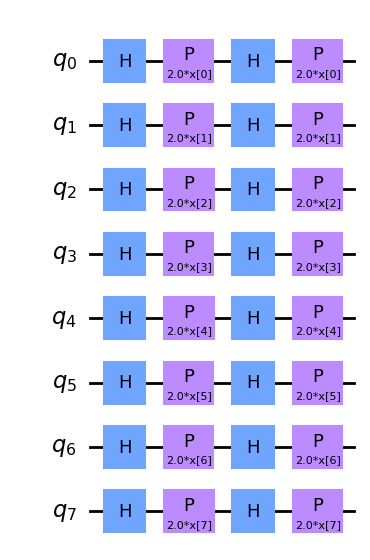

In [10]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

We create a function for our QCNN, which will contain three sets of alternating convolutional and pooling layers, which can be seen in the schematic below. Through the use of the pooling layers, we thus reduce the dimensionality of our QCNN from eight qubits to one. 

![Screenshot%202022-08-10%20at%2021.42.39.png](attachment:Screenshot%202022-08-10%20at%2021.42.39.png)

To classify our image dataset of horizontal and vertical lines, we measure the expectation value of the Pauli Z operator of the final qubit. Based on the obtained value being +1 or -1, we can conclude that the input image contained either a horizontal or vertical line. 

## 5. Training our QCNN

The next step is to build our model using our training data. 

To classify our system, we perform a measurement from the output circuit. The value we obtain will thus classify whether our input data contains either a vertical line or horizontal line. 

The measurement we have chosen in this tutorial is $<Z>$, i.e. the expectation value of the Pauli Z qubit for the final qubit. Measuring this expectation value, we obtain +1 or -1, which correspond to a vertical or horizontal line respectively. 

In [11]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

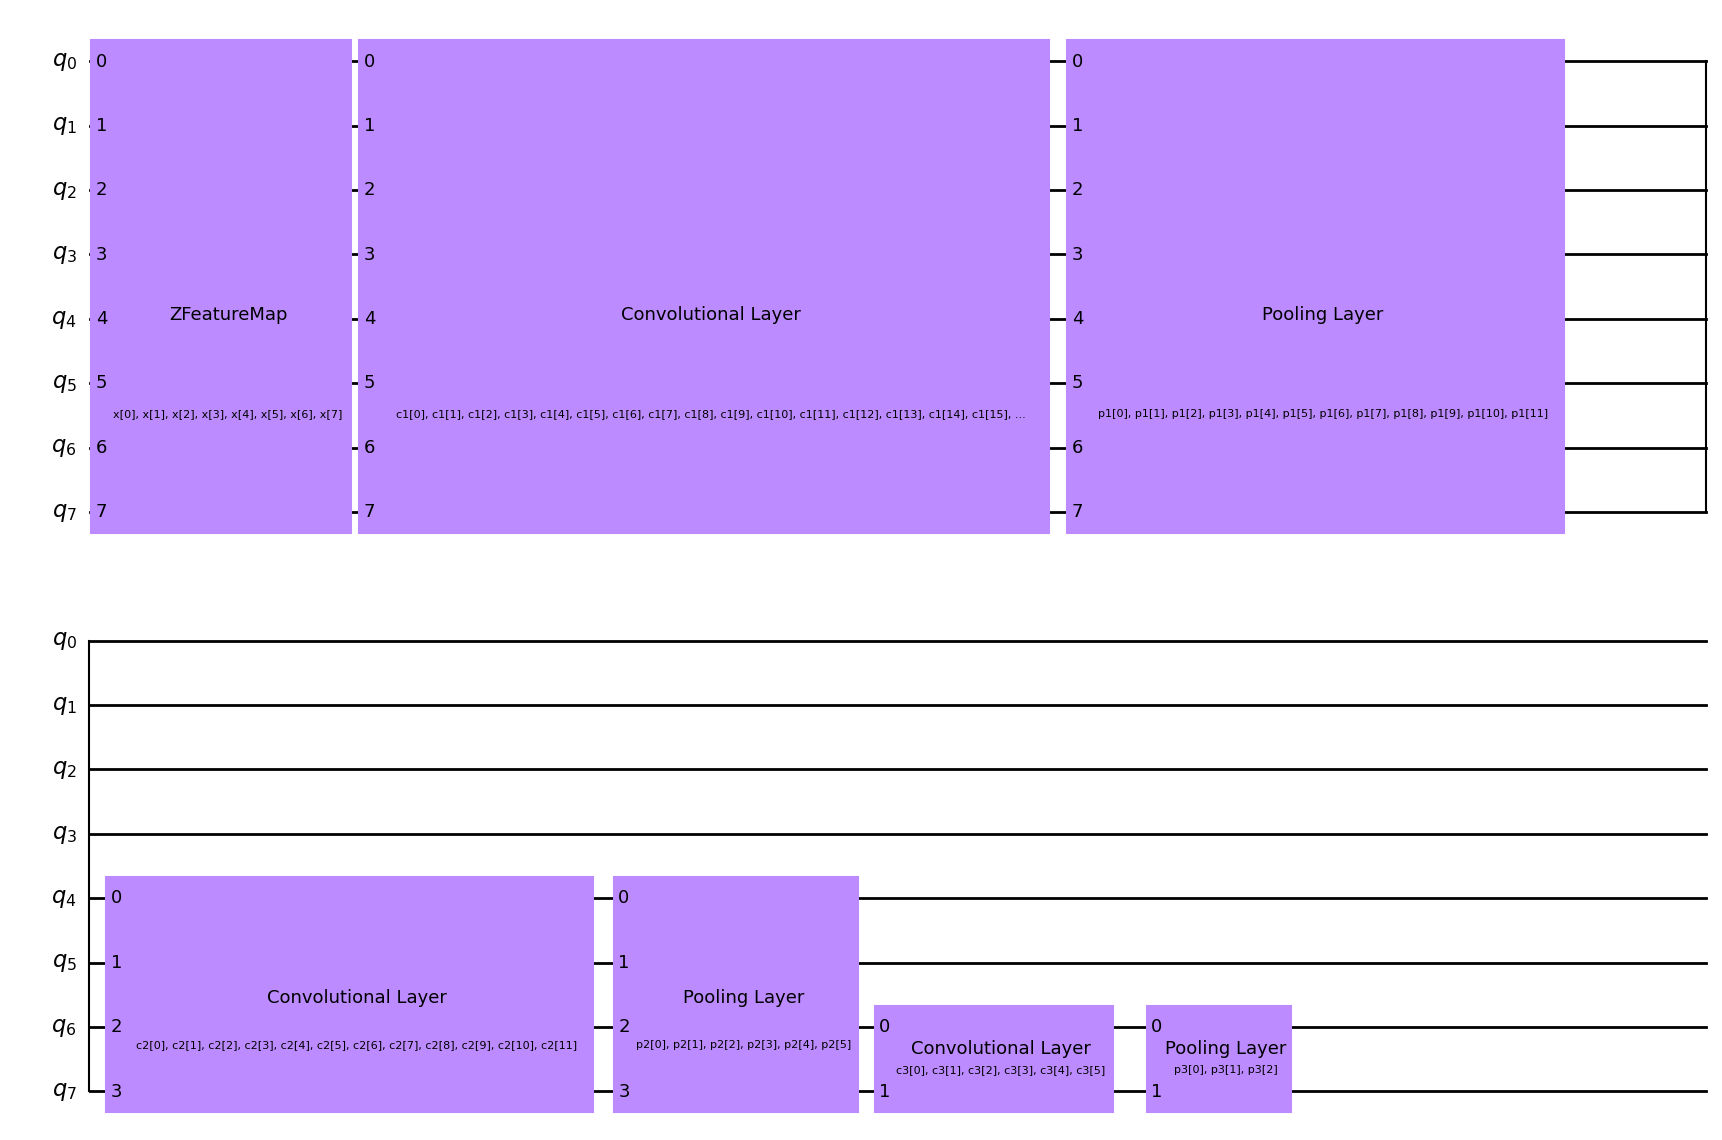

In [12]:
circuit.draw("mpl")

We will also define a callback function to use when training our model. This allows us to view and plot the loss function per each iteration in our training process.

In [13]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In this example, we will use the COBYLA optimizer to train our classifier, which is a numerical optimization method commonly used for classification machine learning algorithms.

We then place the the callback function, optimizer and operator of our QCNN created above into Qiskit's built in Neural Network Classifier, which we can then use to train our model. 

Since model training may take a long time we have already pre-trained the model for some iterations and saved the pre-trained weights. We'll continue training from that point by setting `initial_point` to a vector of pre-trained weights.

In [15]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

After creating this classifier, we can train our QCNN using our training dataset and each image's corresponding label. Because we previously defined the callback function, we plot the overall loss of our system per iteration.

It may take some time to train the QCNN so be patient!

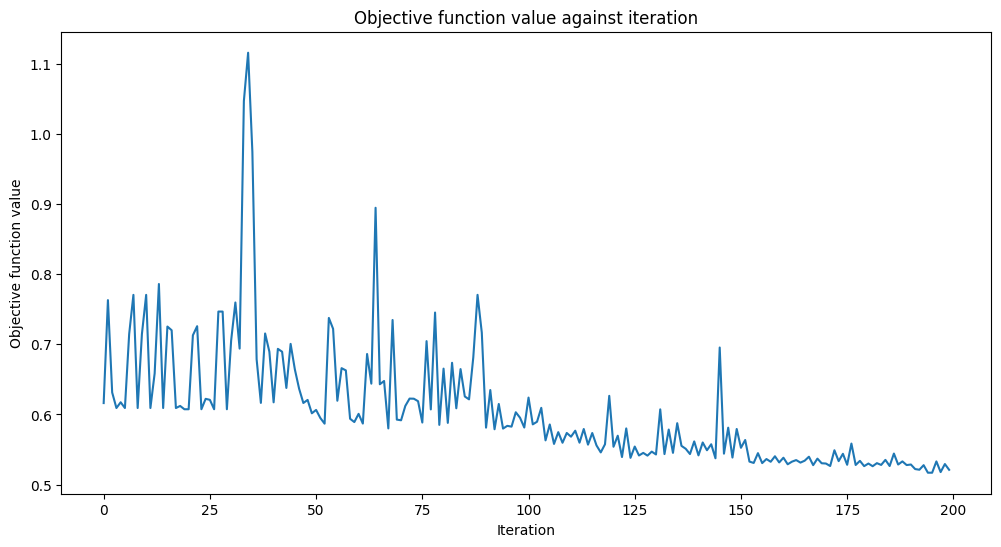

Accuracy from the train data : 88.57%


In [16]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

As we can see from above, the QCNN converges slowly, hence our `initial_point` was already close to an optimal solution. The next step is to determine whether our QCNN can classify data seen in our test image data set. 

## 6. Testing our QCNN

After building and training our dataset we now test whether our QCNN can predict images that are not from our test data set. 

Accuracy from the test data : 80.0%


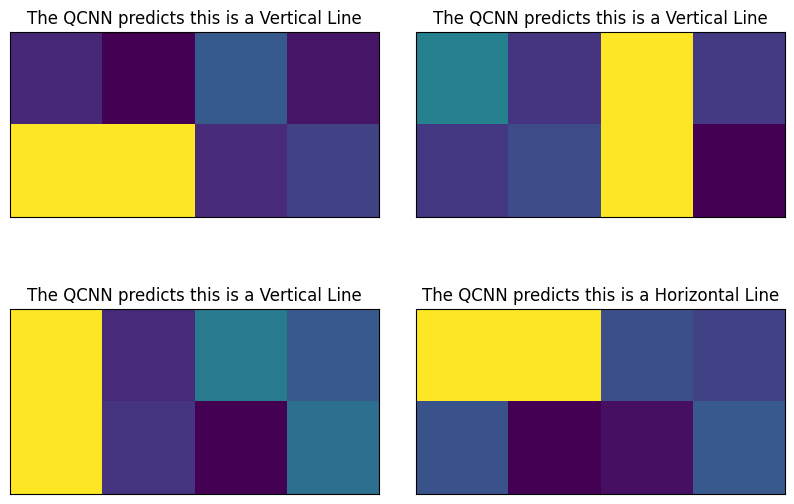

In [17]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

From above, we can indeed see that our QCNN can classify horizontal and vertical lines! Congratulations! Through the use of quantum circuits and quantum convolutional and pooling layers, you have built a Quantum Convolutional Neural Network! 

## 7. References

[1] Cong, I., Choi, S. & Lukin, M.D. Quantum convolutional neural networks. Nat. Phys. 15, 1273–1278 (2019). https://doi.org/10.1038/s41567-019-0648-8

[2] IBM Convolutional Neural Networks https://www.ibm.com/cloud/learn/convolutional-neural-networks

[3] Vatan, Farrokh, and Colin Williams. "Optimal quantum circuits for general two-qubit gates." Physical Review A 69.3 (2004): 032315.

In [18]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright